In [36]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
import numpy as np
import hdbscan
import os.path

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Preparation

In [37]:
import pandas as pd
import os.path
FILEID = 1
FILEIDS = [1, 3, 36, 39, 49, 52]
LOGFILE = f"https://mcfp.felk.cvut.cz/publicDatasets/IoTDatasets/CTU-IoT-Malware-Capture-{FILEID}-1/bro/conn.log.labeled"
NUMERIC_COLUMNS = ['ts', 'orig_p', 'resp_p', "orig_bytes", "resp_bytes", "missed_bytes", "orig_pkts", 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'duration'] # integer columns

In [38]:
def convert_to_csv(FILEID):
    if not os.path.isfile(f'csv/capture{FILEID}_1.csv'):
        LOGFILE = f"https://mcfp.felk.cvut.cz/publicDatasets/IoTDatasets/CTU-IoT-Malware-Capture-{FILEID}-1/bro/conn.log.labeled"
        fieldsIN = ['ts', 'uid', 'orig_h', 'orig_p', 'resp_h', 'resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state',
                'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'label', 'detailed_label']
        df = pd.read_csv(LOGFILE, sep="\x09|\x20\x20\x20", skiprows=10, skipfooter=2,
                        names=fieldsIN, header=None, engine='python')
        df = df.drop(['tunnel_parents'], axis=1)
        df.to_csv(f'csv/capture{FILEID}_1.csv')
        print(df.shape)
        for column in NUMERIC_COLUMNS:
            df[column] = pd.to_numeric(df[column], errors='coerce')
        return df


In [39]:
SOURCEDF = pd.read_csv('csv/capture1_1.csv')
SOURCEDF = SOURCEDF.replace('-', np.NaN)

SOURCEDF.head()

,Unnamed: 0,ts,uid,orig_h,orig_p,resp_h,resp_p,proto,service,duration,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,detailed_label
0,0,1.525880e+09,C3GBTkINvXNjVGtN5,192.168.100.103,41101,111.40.23.49,23,tcp,NaN,NaN,...,NaN,NaN,0,S,1,60,0,0,Malicious,PartOfAHorizontalPortScan
1,1,1.525880e+09,CDe43c1PtgynajGI6,192.168.100.103,60905,131.174.215.147,23,tcp,NaN,2.998796,...,NaN,NaN,0,S,3,180,0,0,Malicious,PartOfAHorizontalPortScan
2,2,1.525880e+09,CJaDcG3MZzvf1YVYI4,192.168.100.103,44301,91.42.47.63,23,tcp,NaN,NaN,...,NaN,NaN,0,S,1,60,0,0,Malicious,PartOfAHorizontalPortScan
3,3,1.525880e+09,CMBrup3BLXivSp4Avc,192.168.100.103,50244,120.210.108.200,23,tcp,NaN,NaN,...,NaN,NaN,0,S,1,60,0,0,Malicious,PartOfAHorizontalPortScan
4,4,1.525880e+09,CfHl9r3XMYtDQRrHnh,192.168.100.103,34243,147.7.65.203,49560,tcp,NaN,2.998804,...,NaN,NaN,0,S,3,180,0,0,Benign,NaN


## Clustering

In [40]:
def hdbscanner(df):
    hdbscan_obj = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, metric='euclidean', min_cluster_size=5, min_samples=None, p=None).fit(df)
    labels = hdbscan_obj.labels_
    df['category'] = pd.Series(labels)

    return df


In [41]:
# takes 3m52.2s
ROWS = 10000
df1_ = SOURCEDF.loc[:ROWS, ['orig_bytes','resp_bytes','orig_p', 'resp_p']]
df1 = hdbscanner(df1_)

In [42]:
df1.head(10)


,orig_bytes,resp_bytes,orig_p,resp_p,category
0,NaN,NaN,41101,23,-1
1,0,0,60905,23,25
2,NaN,NaN,44301,23,-1
3,NaN,NaN,50244,23,-1
4,0,0,34243,49560,-1
5,NaN,NaN,34840,21288,-1
6,NaN,NaN,58525,23,-1
7,NaN,NaN,43849,8080,-1
8,NaN,NaN,40973,8080,-1
9,0,0,52259,23,16


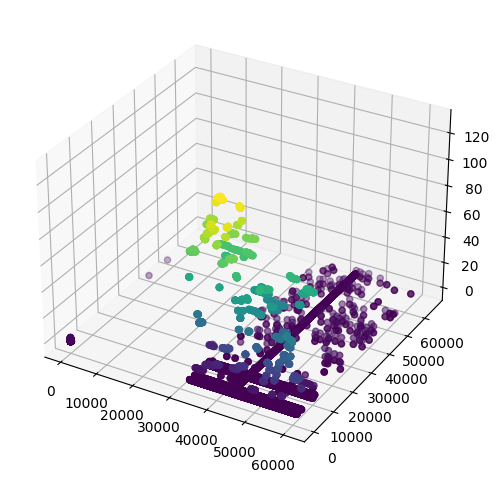

In [43]:
fig = plt.figure(figsize=(6,6))

ax = plt.axes(projection='3d')
#sc = ax.scatter(data=df1, x='orig_p', y='resp_p', z='category', s=40, c='category', marker='o', cmap='plasma', alpha=1)

ax.scatter3D(df1['orig_p'], df1['resp_p'], df1['category'], c=df1['category'])

plt.show()

## Model Training using linear Kernel

In [44]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


In [45]:

X = df1[['orig_p', 'resp_p']]
y = df1['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)


In [46]:
# The SVC Class from Sklearn
#clf = SVC(*,
#    C=1.0,                          # The regularization parameter
#    kernel='rbf',                   # The kernel type used 
#    degree=3,                       # Degree of polynomial function 
#    gamma='scale',                  # The kernel coefficient
#    coef0=0.0,                      # If kernel = 'poly'/'sigmoid'
#    shrinking=True,                 # To use shrinking heuristic
#    probability=False,              # Enable probability estimates
#    tol=0.001,                      # Stopping crierion
#    cache_size=200,                 # Size of kernel cache
#    class_weight=None,              # The weight of each class
#    verbose=False,                  # Enable verbose output
#    max_iter=- 1,                   # Hard limit on iterations
#    decision_function_shape='ovr',  # One-vs-rest or one-vs-one
#    break_ties=False,               # How to handle breaking ties
#    random_state=None               # Random state of the model
#)

In [47]:
# Building and training our model
clf = SVC(kernel='linear', verbose=False)
clf.fit(X_train, y_train)
# interrupted after 526 minutes

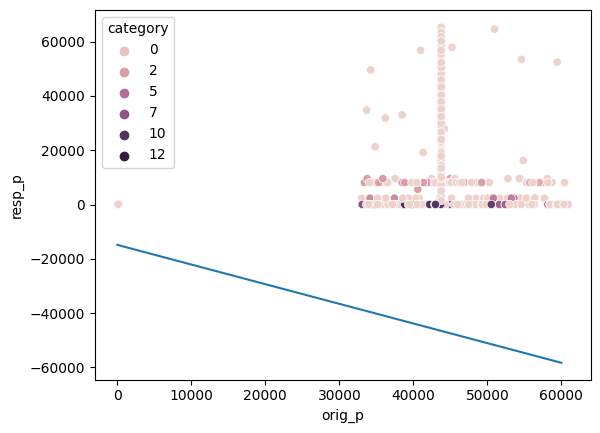

In [ ]:
# Visualizing the linear function for our SVM classifier
import numpy as np
from seaborn import scatterplot
w = clf.coef_[0]
b = clf.intercept_[0]
x_visual = np.linspace(0,60000)
y_visual = -(w[0] / w[1]) * x_visual - b / w[1]

scatterplot(data = X_train, x='orig_p', y='resp_p', hue=y_train)
plt.plot(x_visual, y_visual)
plt.show()

## Model Training using better Kernel

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer